Main Leaderboard

Forecaster  | Peer score against Pros | % Beat Pros on same Qs (Bootstrap) | % Beat Pros on same Qs (Resample)

Resample: Linear interpolation of two forecasters to determine "ground truth" for resampling. "Ground truth" = weighted combination of percent forecasts on each question that yields the most accurate score. Weights are 0 to 1.

Correlation: Deal with by assigning weights to questions. Weights for independent questions are 1. "Approximately correct rather than precisely wrong." Would be good to have a rule of thumb. These weights can be used for leaderboard above.

Likely want % beat Pros to be beyond 95% for significance - but obviously a sliding scale.

Can use this method for Metaculus Track Record! Have separate line for each platform - so can see significance against each platform. Then combine all competeing platforms and treat as the same forecaster going head-to-head against Metaculus!

In [1]:
# @title Import libraries & Google drive
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import minimize_scalar
from datetime import datetime
from scipy import stats

In [2]:
# @title Create df_bot_resolved_questions, df_pro_resolved_questions, df_pro_bot_resolved_questions, df_bot_question_weights

# TK: GROUP QUESTIONS?!

"""
Input question data for both bots and pros.

Only look at questions that have resolved Yes or No.

df_pro_resolved_questions: Has pro_question_id, title, resolution, scheduled_close_time
df_bot_resolved_questions: Has bot_question_id, title, resolution, scheduled_close_time

All pro questions are asked to bots, but not all bot questions are asked to pros (correction:
not true in 2024 Q4, there were some that got launched to pros first? and were bad so they
didn't get asked of bots?)

To compare pros to bots, we need to match the pro_question_id with the bot_question_id.
This is done by matching the title and scheduled_close_time.

We remove early closers from the analysis. I do this by comparing actual close time to scheduled
close time in a later cell!

df_pro_bot_resolved_questions: Has pro_question_id, bot_question_id, title, resolution, scheduled_close_time, question_weight
"""

df_bot_questions = pd.read_csv('scores/bots_score_data_q3.csv')
df_bot_questions = df_bot_questions.rename(columns={'question_id': 'bot_question_id', 'question_title': 'title'})

df_pro_questions = pd.read_csv('scores/pros_score_data_q3.csv')
df_pro_questions = df_pro_questions.rename(columns={'question_id': 'pro_question_id', 'question_title': 'title'})

filtered_df = df_pro_questions[df_pro_questions['resolution'].isin(['yes', 'no'])]
df_pro_resolved_questions = filtered_df[['pro_question_id', 'title', 'resolution', 'scheduled_close_time', 'actual_close_time', 'question_weight']]

filtered_df = df_bot_questions[df_bot_questions['resolution'].isin(['yes', 'no'])]
df_bot_resolved_questions = filtered_df[['bot_question_id', 'title', 'resolution', 'scheduled_close_time', 'actual_close_time', 'question_weight']]

df_pro_bot_resolved_questions = pd.merge(
    df_pro_resolved_questions,
    df_bot_resolved_questions[['bot_question_id', 'title', 'scheduled_close_time', 'question_weight']],
    on=['title', 'scheduled_close_time'],
    how='left'
)

df_pro_bot_resolved_questions['question_weight'] = df_pro_bot_resolved_questions['question_weight_x'].combine_first(df_pro_bot_resolved_questions['question_weight_y'])
df_pro_bot_resolved_questions.drop(['question_weight_x', 'question_weight_y'], axis=1, inplace=True)

# Remove duplicates
df_pro_bot_resolved_questions = df_pro_bot_resolved_questions.drop_duplicates()

# Remove questions that never got posed to bots
df_pro_bot_resolved_questions = df_pro_bot_resolved_questions.dropna(subset=['bot_question_id'])

# Cast both question ids to int64
df_pro_bot_resolved_questions['pro_question_id'] = df_pro_bot_resolved_questions['pro_question_id'].astype('int64')
df_pro_bot_resolved_questions['bot_question_id'] = df_pro_bot_resolved_questions['bot_question_id'].astype('int64')

# Remove df_bot_resolved_questions and df_pro_resolved_questions to make sure you only ever use df_pro_bot_resolved_questions
del df_bot_resolved_questions
del df_pro_resolved_questions

In [3]:
# Unique pro questions, bot questions
pro_questions = df_pro_bot_resolved_questions['pro_question_id'].unique()
bot_questions = df_pro_bot_resolved_questions['bot_question_id'].unique()
print(pro_questions, bot_questions)

[25887 25888 25889 25890 25891 25940 25941 25942 25969 25970 25971 25972
 25973 25974 25975 25976 26031 26032 26033 26034 26035 26141 26142 26143
 26144 26145 26201 26202 26223 26224 26225 26226 26240 26241 26242 26315
 26316 26317 26396 26397 26398 26412 26413 26414 26588 26589 26590 26591
 26592 26593 26595 26596 26597 26648 26677 26678 26679 26680 26681 26685
 26711 26712 26713 26714 26793 26794 26795 26796 26797 26798 26799 26800
 26801 26802 26803 26804 26805 26806 26807 26808 26809 26846 26930 26951
 26952 26953 26999 27000 27001 27002 27003 27004 27005 27006 27007 27008
 27009 27010 27145 27146 27147 27149 27150 27151 27163 27202 27229 27230
 27231 27232 27233 27242 27243 27244 27245 27250 27267 27268 27269 27287
 27451 27504 27505 27506 27507 27508 27509 27510 27511 27512 27513 27516
 27736 27737 27751 27752 27753 27754 27755 27924 27925 27926 27940 27941
 27942 27943 28026 28057 28058 28059 28060 28061 28062 28063 28064 28065
 28066] [25871 25872 25873 25874 25875 26004 26005 

In [4]:
# Number of questions in pro_bot_resolved_questions
print('Number of unique questions in df_pro_bot_resolved_questions:', len(df_pro_bot_resolved_questions['bot_question_id']))

Number of unique questions in df_pro_bot_resolved_questions: 157


In [5]:
# Remove early closers (questions that resolved before the scheduled close time)
remove_early_closers = True
if remove_early_closers:
  df_pro_bot_resolved_questions = df_pro_bot_resolved_questions[df_pro_bot_resolved_questions['actual_close_time'] <= df_pro_bot_resolved_questions['scheduled_close_time']]

In [6]:
# Step 1: Read in the scores dataclips from heroku, take last (spot) score for each question_id, forecaster pair; make it into what Tom's code expects

## BOTS

df_bot_scores = pd.read_csv('scores/bots_score_data_q3.csv')
# IMPORTANT: ONLY KEEP THE QUESTIONS IN DF_PRO_BOT_RESOLVED_QUESTIONS
df_bot_scores = df_bot_scores[df_bot_scores['question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]

# BASELINE
df_bot_baseline = df_bot_scores[df_bot_scores['score_type'] == 'baseline']

# Take the LAST score for each (forecaster, question_id) pair
df_bot_baseline = df_bot_baseline.groupby(['question_id', 'forecaster']).last().reset_index()

# PEER
df_bot_peer = df_bot_scores[df_bot_scores['score_type'] == 'spot_peer']

# Take the LAST score for each (forecaster, question_id) pair
df_bot_peer = df_bot_peer.groupby(['question_id', 'forecaster']).last().reset_index()

## PROS

df_pro_scores = pd.read_csv('scores/pros_score_data_q3.csv')
# IMPORTANT: ONLY KEEP THE QUESTIONS IN DF_PRO_BOT_RESOLVED_QUESTIONS
df_pro_scores = df_pro_scores[df_pro_scores['question_id'].isin(df_pro_bot_resolved_questions['pro_question_id'])]

# BASELINE
df_pro_baseline = df_pro_scores[df_pro_scores['score_type'] == 'baseline']

# Take the LAST score for each (forecaster, question_id) pair
df_pro_baseline = df_pro_baseline.groupby(['question_id', 'forecaster']).last().reset_index()
df_pro_baseline_long = df_pro_baseline.copy()

# ADD THE BOT MEDIAN SPOT SCORE & REMOVE UNNECESSARY COLUMNS
df_bot_baseline = df_bot_baseline[['question_id', 'question_title', 'question_weight', 'forecaster', 'score', 'resolution']]

# Calculate medians and preserve metadata
medians = (df_bot_baseline
    .groupby(['question_id', 'question_title', 'question_weight'])['score']
    .median()
    .reset_index()
    .assign(forecaster='bot_median')
)

# Combine with original data
df_bot_baseline = pd.concat([df_bot_baseline, medians])
df_bot_baseline_long = df_bot_baseline.copy()

# DO THE SAME FOR DF_BOT_PEER
df_bot_peer = df_bot_peer[['question_id', 'question_title', 'question_weight', 'forecaster', 'score', 'resolution']]

# Get all columns except score and forecaster
medians = (df_bot_peer
    .groupby(['question_id', 'question_title', 'question_weight'])['score']
    .median()
    .reset_index()
    .assign(forecaster='bot_median')
)

# Combine with original data
df_bot_peer = pd.concat([df_bot_peer, medians])

df_bot_baseline_long.head()

,question_id,question_title,question_weight,forecaster,score,resolution
0,25871,"On July 17, 2024, will Nvidia's market capital...",1.0,000_bot,-46.310770,no
1,25871,"On July 17, 2024, will Nvidia's market capital...",1.0,Bot_Pepa,91.268263,no
2,25871,"On July 17, 2024, will Nvidia's market capital...",1.0,Cassie,74.886736,no
3,25871,"On July 17, 2024, will Nvidia's market capital...",1.0,HSeldon,72.712280,no
4,25871,"On July 17, 2024, will Nvidia's market capital...",1.0,Jay_Bailey_Bot,-2.840924,no


In [7]:
# Step 2: FILTER TO ONLY THOSE QUESTION ID's THAT ARE IN DF_PRO_BOT_RESOLVED_QUESTIONS
df_bot_peer = df_bot_peer[df_bot_peer['question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]
df_bot_baseline = df_bot_baseline[df_bot_baseline['question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]
df_bot_baseline_long = df_bot_baseline_long[df_bot_baseline_long['question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]
df_pro_baseline = df_pro_baseline[df_pro_baseline['question_id'].isin(df_pro_bot_resolved_questions['pro_question_id'])]
df_pro_baseline_long = df_pro_baseline_long[df_pro_baseline_long['question_id'].isin(df_pro_bot_resolved_questions['pro_question_id'])]
df_bot_scores = df_bot_scores[df_bot_scores['question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]
df_pro_scores = df_pro_scores[df_pro_scores['question_id'].isin(df_pro_bot_resolved_questions['pro_question_id'])]

In [8]:
all_bots = df_bot_peer['forecaster'].unique()
all_bots

array(['000_bot', 'Bot_Pepa', 'Cassie', 'HSeldon', 'Jay_Bailey_Bot',
       'MWG', 'ProfPaul', 'RonanMcGovern', 'RyansAGI', 'VeritasAI',
       'amaster1997', 'annabot', 'archipelago', 'botaska', 'egriffiths',
       'elliotdevbot', 'gnosis-ai', 'lapp0', 'manticAI', 'mf-bot-1',
       'mf-bot-2', 'peacefulwarrior+bot', 'pgodzinai', 'pythoness',
       'reproducible', 'twsummerbot', 'kiko-bot', 'GMEToTheMoon',
       'InstitutPelFutur', 'Merlins-beard', 'apl-delphi', 'centobot',
       'cmsilva', 'jkraybill_bot', 'p-bot', 'doland', 'nikolabot',
       'guardianai_io', 'bestworldbot', 'bot_denis_1', 'Panshul42',
       'tonythequick', 'usmanijan', 'histerio', 'mf-bot-3', 'GreeneiBot',
       'acm_bot', 'biak_bot', 'royal7', 'Unwrapped80T', 'SynapseSeer',
       'bot_median'], dtype=object)

In [9]:
# Unique score_type in df_bot_scores
df_bot_scores['score_type'].unique()

array(['baseline', 'peer', 'spot_peer'], dtype=object)

In [10]:
def calculate_weighted_stats(df):
    results = []
    
    # For each forecaster
    for forecaster in df['forecaster'].unique():
        forecaster_data = df[df['forecaster'] == forecaster]
        
        # Get scores and weights
        scores = forecaster_data['score']
        weights = forecaster_data['question_weight']
        
        # Calculate weighted mean
        weighted_mean = np.average(scores, weights=weights)
        weighted_sum = np.sum(scores * weights)
        
        # Calculate weighted standard error
        # Using weighted variance formula
        weighted_var = np.average((scores - weighted_mean)**2, weights=weights)
        n = len(scores)
        weighted_se = np.sqrt(weighted_var / n)
        
        # Calculate t-statistic for 95% confidence interval
        t_value = stats.t.ppf(0.975, n-1)
        ci_lower = weighted_mean - (t_value * weighted_se)
        
        results.append({
            'forecaster': forecaster,
            'weighted_mean': weighted_mean,
            'weighted_sum': weighted_sum,
            'n_questions': n,
            'ci_lower': ci_lower,
            'weighted_se': weighted_se
        })
    
    # Convert to dataframe and sort by lower bound
    results_df = pd.DataFrame(results)
    return results_df.sort_values('weighted_sum', ascending=False)

# Calculate and show results
ranked_forecasters = calculate_weighted_stats(df_bot_peer)

ranked_forecasters.head(10)

,forecaster,weighted_mean,weighted_sum,n_questions,ci_lower,weighted_se
5,MWG,13.338354,2040.768190,153,9.592147,1.896147
51,bot_median,11.163109,1752.608104,157,9.649074,0.766488
43,histerio,12.608385,1626.481615,129,6.564425,3.054556
19,mf-bot-1,9.396996,1475.328375,157,2.224224,3.631255
2,Cassie,8.935779,1331.431028,149,3.094570,2.955894
46,acm_bot,12.792291,1266.436806,99,8.329956,2.248631
31,centobot,12.327278,1232.727812,100,5.155714,3.614304
4,Jay_Bailey_Bot,7.783362,1221.987886,157,3.916016,1.957865
44,mf-bot-3,9.626153,1116.633787,116,0.416748,4.649319
11,annabot,6.979948,1074.912067,154,2.751941,2.140124


In [11]:
# @title Create df_bot_baseline, df_bot_peer, df_bot_forecasts, bots

"""
df_bot_baseline: Spot Baseline scores for all bots & bot_median

df_bot_peer: Spot Peer scores for all bots & bot_median. Can be used to recreate
the tournament leaderboard on the site.

df_bot_forecasts: Spot forecasts for all bots & bot_median, ie only counts the
final forecast

bots: a list of all bots
"""

# Pivot df_bot_baseline
df_bot_baseline = df_bot_baseline.rename(columns={'question_id': 'bot_question_id'})
#df_bot_baseline['score'] = pd.to_numeric(df_bot_baseline['score'], errors='coerce')
df_pivoted = df_bot_baseline.pivot(index='bot_question_id', columns='forecaster', values='score')
df_pivoted = df_pivoted.reset_index()
df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)

# Move 'question_id' to be the first column
cols = df_pivoted.columns.tolist()
cols = ['bot_question_id'] + [col for col in cols if col != 'bot_question_id']
df_pivoted = df_pivoted[cols]

all_columns = df_pivoted.columns.tolist()
# Remove 'question_id' and 'bot_median' from the list if they exist
all_columns = [col for col in all_columns if col not in ['bot_question_id', 'bot_median']]
new_column_order = ['bot_question_id', 'bot_median'] + all_columns
df_pivoted = df_pivoted[new_column_order]
df_bot_baseline_wide = df_pivoted
df_bot_baseline_wide['bot_question_id'] = pd.to_numeric(df_bot_baseline_wide['bot_question_id'], errors='coerce')

# Create df_bot_peer
df_bot_peer = df_bot_peer.rename(columns={'question_id': 'bot_question_id'})
df_bot_peer['score'] = pd.to_numeric(df_bot_peer['score'], errors='coerce')
df_pivoted = df_bot_peer.pivot(index='bot_question_id', columns='forecaster', values='score')
df_pivoted = df_pivoted.reset_index()
df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)

# Step 4: Move 'question_id' to be the first column
cols = df_pivoted.columns.tolist()
cols = ['bot_question_id'] + [col for col in cols if col != 'bot_question_id']
df_pivoted = df_pivoted[cols]

all_columns = df_pivoted.columns.tolist()
## Remove 'question_id' and 'bot_median' from the list if they exist
all_columns = [col for col in all_columns if col not in ['bot_question_id', 'bot_median']]
new_column_order = ['bot_question_id', 'bot_median'] + all_columns
df_pivoted = df_pivoted[new_column_order]
df_bot_peer_wide = df_pivoted
df_bot_peer_wide['bot_question_id'] = pd.to_numeric(df_bot_peer_wide['bot_question_id'], errors='coerce')

In [12]:
################ CONVERT BASELINE SCORE TO FORECAST ###################

def convert_baseline_to_forecasts(df):
    # Assumes columns: 'bot_question_id' 'resolution'
    result_df = df.copy()

    def score_to_forecast(score, resolution):
        if resolution == 'yes':
            return 2 ** (score/100 - 1)
        else:
            return 1 - 2 ** (score/100 - 1)

    score_columns = ['score']
    #score_columns = [col for col in score_columns if col not in ['bot_question_id', 'resolution', 'pro_question_id']]

    for col in score_columns:
        result_df['forecast'] = result_df.apply(lambda row: score_to_forecast(row[col], row['resolution']), axis=1)

    return result_df

#df_temp = pd.merge(
    #df_bot_baseline,
    #df_bot_resolved_questions[['bot_question_id', 'resolution']],
    #on='bot_question_id',
    #how='left'
#)

df_bot_forecasts = convert_baseline_to_forecasts(df_bot_baseline)
df_bot_forecasts = df_bot_forecasts.drop('resolution', axis=1)

#print(f"Shape of df_bot_forecasts: {df_bot_forecasts.shape}")
#print(df_bot_forecasts.columns)

df_bot_forecasts.head()

,bot_question_id,question_title,question_weight,forecaster,score,forecast
0,25871,"On July 17, 2024, will Nvidia's market capital...",1.0,000_bot,-46.310770,0.637289
1,25871,"On July 17, 2024, will Nvidia's market capital...",1.0,Bot_Pepa,91.268263,0.058729
2,25871,"On July 17, 2024, will Nvidia's market capital...",1.0,Cassie,74.886736,0.159764
3,25871,"On July 17, 2024, will Nvidia's market capital...",1.0,HSeldon,72.712280,0.172333
4,25871,"On July 17, 2024, will Nvidia's market capital...",1.0,Jay_Bailey_Bot,-2.840924,0.509750


In [13]:
# @title Bot Baseline Leaderboard

# Calculate the total score for each bot
total_scores = df_bot_baseline_wide.iloc[:, 1:].fillna(0).sum()

# Create a new dataframe with the total scores
df_total_scores = pd.DataFrame({'Bot': total_scores.index, 'Baseline_Score': total_scores.values})

# Sort the dataframe by Total_Score in descending order
df_total_scores_sorted = df_total_scores.sort_values('Baseline_Score', ascending=False)

# Add a Rank column
df_total_scores_sorted['Rank'] = range(1, len(df_total_scores_sorted) + 1)

# Set Rank as the index
df_total_scores_ranked = df_total_scores_sorted.set_index('Rank')

# Display the result
df_total_scores_ranked

,Bot,Baseline_Score
Rank,,
1,histerio,2136.178547
2,mf-bot-1,2125.174523
3,mf-bot-3,1734.390939
4,pgodzinai,1686.834217
5,InstitutPelFutur,1596.295177
6,Jay_Bailey_Bot,1479.193411
7,bot_median,1392.884090
8,Unwrapped80T,1014.339060
9,VeritasAI,1001.684453


In [14]:
df_total_scores_sorted

,Bot,Baseline_Score,Rank
34,histerio,2136.178547,1
39,mf-bot-1,2125.174523,2
41,mf-bot-3,1734.390939,3
45,pgodzinai,1686.834217,4
7,InstitutPelFutur,1596.295177,5
8,Jay_Bailey_Bot,1479.193411,6
0,bot_median,1392.884090,7
16,Unwrapped80T,1014.339060,8
17,VeritasAI,1001.684453,9
6,HSeldon,970.795839,10


In [15]:
df_filled = df_bot_peer_wide.fillna(0)

In [16]:
# @title Bot Peer Leaderboard

"""
NOTE: This can be different from the leaderboad on the site IF early closers
are excluded (check remove_early_closers bool).
"""

df_filled = df_bot_peer_wide.fillna(0)
#df_filled = df_filled.drop(['bot_question_id', 'question_weight'], axis=1)

# Calculate the total score for each player
total_scores = df_filled.sum()

# Create a new DataFrame for the leaderboard
leaderboard = pd.DataFrame({
    'bot': total_scores.index,
    'Peer Score': total_scores.values
})

# Remove bot_question_id from the leaderboard
leaderboard = leaderboard[leaderboard['bot'] != 'bot_question_id']

# Sort the leaderboard by Total Score in descending order
leaderboard = leaderboard.sort_values('Peer Score', ascending=False)

# Reset the index and add a 'Rank' column
leaderboard = leaderboard.reset_index(drop=True)
leaderboard.index += 1
leaderboard.index.name = 'Rank'

# Display the leaderboard
leaderboard

,bot,Peer Score
Rank,,
1,MWG,2040.768190
2,bot_median,1752.608104
3,histerio,1626.481615
4,mf-bot-1,1475.328375
5,Cassie,1331.431028
6,acm_bot,1266.436806
7,centobot,1232.727812
8,Jay_Bailey_Bot,1221.987886
9,mf-bot-3,1116.633787


In [17]:
# ADD PRO_MEDIAN ROWS

df_pro_scores = df_pro_baseline

# Create pro_median: for each question, calculate the median score
median_scores = df_pro_scores.groupby('question_id')['score'].median().reset_index()
median_scores = median_scores.rename(columns={'score': 'median_score'})  # rename to avoid confusion

# Create template rows with metadata
template_rows = df_pro_scores.groupby('question_id').first().reset_index()

# Create new rows with median scores
median_rows = template_rows.merge(median_scores, on='question_id', how='left')
median_rows['forecaster'] = 'pro_median'
median_rows['score'] = median_rows['median_score']  # assign the median to score column
median_rows = median_rows.drop('median_score', axis=1)  # clean up temporary column

# Concatenate original DataFrame with new median rows
df_combined = pd.concat([df_pro_scores, median_rows], ignore_index=True)

df_pro_scores = df_combined

df_combined.tail()

,question_id,forecaster,question_title,created_at,user_id,score,score_type,resolution,scheduled_close_time,actual_close_time,question_weight,post_id
1624,28062,pro_median,Will AfD's vote share be more than 32% in the ...,2024-09-10 13:43:01.935446+00,120160,22.453655,baseline,no,2024-09-13 14:30:00+00,2024-09-13 14:30:00+00,1.0,28062
1625,28063,pro_median,Will AfD's vote share be more than 30% and les...,2024-09-10 13:43:02.049921+00,120160,10.243507,baseline,no,2024-09-13 14:30:00+00,2024-09-13 14:30:00+00,1.0,28063
1626,28064,pro_median,Will AfD's vote share be more than 28% and les...,2024-09-10 13:43:02.164334+00,120160,-25.712563,baseline,yes,2024-09-13 14:30:00+00,2024-09-13 14:30:00+00,1.0,28064
1627,28065,pro_median,Will AfD's vote share be less than or equal to...,2024-09-10 13:43:02.314214+00,120160,19.787048,baseline,no,2024-09-13 14:30:00+00,2024-09-13 14:30:00+00,1.0,28065
1628,28066,pro_median,Will the lithium carbonate (CNY/T) price fall ...,2024-09-10 13:43:02.513449+00,120160,-18.743322,baseline,no,2024-09-13 14:30:00+00,2024-09-13 14:30:00+00,1.0,28066


In [18]:
df_bot_scores = df_bot_scores[df_bot_scores['score_type'] == 'baseline']

In [19]:
# @title Create df_pro_baseline, df_pro_forecasts

"""
WARNING: This may not exclude early closers.

df_pro_baseline: Spot Baseline scoes for all pros & pro_median

df_pro_forecasts: Spot forecasts for all pros & pro_median
"""

# Pivot df_pro_scores (baseline)
#df_pro_scores = df_pro_scores.rename(columns={'question_id': 'pro_question_id'})
#df_pivoted = df_pro_scores.pivot(index='pro_question_id', columns='forecaster', values='score')
#df_pivoted = df_pivoted.reset_index()
#df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)

#cols = df_pivoted.columns.tolist()
#cols = ['pro_question_id'] + [col for col in cols if col != 'pro_question_id']
#df_pivoted = df_pivoted[cols]

#all_columns = df_pivoted.columns.tolist()
#all_columns = [col for col in all_columns if col not in ['pro_question_id', 'pro_median']]
#new_column_order = ['pro_question_id', 'pro_median'] + all_columns
#df_pivoted = df_pivoted[new_column_order]
#df_pro_baseline = df_pivoted
#df_pro_baseline['pro_question_id'] = pd.to_numeric(df_pro_baseline['pro_question_id'], errors='coerce')


#print(f"Shape of df_pro_baseline: {df_pro_baseline.shape}")
#print(df_pro_baseline.columns)


#df_temp = pd.merge(
    #df_pro_baseline,
    #df_pro_scores[['pro_question_id', 'resolution']],
    #on='pro_question_id',
    #how='left'
#)

df_pro_forecasts = convert_baseline_to_forecasts(df_pro_scores)
df_pro_forecasts = df_pro_forecasts.drop('resolution', axis=1)

df_pro_forecasts.head()

#print(f"Shape of df_pro_forecasts: {df_pro_forecasts.shape}")
#print(df_pro_forecasts.columns)


,question_id,forecaster,question_title,created_at,user_id,score,score_type,scheduled_close_time,actual_close_time,question_weight,post_id,forecast
0,25887,MaciekK,"On July 17, 2024, will Nvidia's market capital...",2024-07-08 12:56:06.013121+00,117580,76.082297,baseline,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,1.0,25887,0.152772
1,25887,OpenSystem,"On July 17, 2024, will Nvidia's market capital...",2024-07-08 12:56:06.013121+00,120160,70.587977,baseline,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,1.0,25887,0.184430
2,25887,Perspectus,"On July 17, 2024, will Nvidia's market capital...",2024-07-08 12:56:06.013121+00,139876,56.398710,baseline,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,1.0,25887,0.260825
3,25887,Zaldath,"On July 17, 2024, will Nvidia's market capital...",2024-07-08 12:56:06.013121+00,139161,80.926668,baseline,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,1.0,25887,0.123840
4,25887,datscilly,"On July 17, 2024, will Nvidia's market capital...",2024-07-08 12:56:06.013121+00,103777,40.248016,baseline,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,1.0,25887,0.339111


In [20]:
# Unique pro_question_ids in df_pro_bot_resolved_questions
df_pro_bot_resolved_questions['bot_question_id'].unique()

array([25871, 25872, 25873, 25874, 25875, 26004, 26005, 26006, 25952,
       25953, 25954, 25955, 25956, 25957, 25958, 25959, 26017, 26018,
       26019, 26022, 26023, 26133, 26134, 26157, 26158, 26159, 26191,
       26192, 26212, 26213, 26214, 26215, 26232, 26233, 26234, 26302,
       26303, 26304, 26390, 26391, 26392, 26405, 26406, 26407, 26568,
       26569, 26570, 26571, 26572, 26573, 26575, 26576, 26577, 26646,
       26665, 26668, 26669, 26670, 26671, 26683, 26700, 26701, 26702,
       26704, 26771, 26772, 26773, 26774, 26775, 26776, 26777, 26778,
       26779, 26780, 26781, 26816, 26817, 26818, 26819, 26820, 26821,
       26844, 26918, 26957, 26958, 26959, 26975, 26976, 26977, 26978,
       26979, 26980, 26981, 26982, 26983, 26984, 26985, 26986, 27138,
       27140, 27141, 27157, 27158, 27159, 27161, 27200, 27219, 27220,
       27221, 27222, 27223, 27238, 27239, 27240, 27241, 27248, 27258,
       27259, 27260, 27281, 27447, 27484, 27485, 27486, 27487, 27488,
       27489, 27490,

In [21]:
# @title Create df_pro_bot_forecasts, df_bot_vs_pro_peer, df_bot_vs_pro_leaderboard, df_bot_vs_pro_weighted_leaderboard

"""
df_pro_bot_forecasts: Spot forecasts for all bots & pro_median, question resolutions, and question weights

df_bot_vs_pro_peer: Calculates Peer scores as if there is a tournament with only
a single bot and the pro_median. This is the main comparison metric for
assessing how a bot compares to the human aggregate. Positive scores mean that
the bot did better than the pro_median. Negative scores mean that the bot did
worse than the pro_median.

df_bot_vs_pro_leaderboard: A leaderboard based on df_bot_vs_pro_peer.

df_bot_vs_pro_weighted_leaderboard: A leaderboard based on df_bot_vs_pro_peer
with question weighting.
"""

# Now pivot df_pro_forecasts; forecaster = columns; forecast = values; index = pro_question_id
df_pro_forecasts = df_pro_forecasts.rename(columns={'question_id': 'pro_question_id'})
df_pro_forecasts = df_pro_forecasts.pivot(index='pro_question_id', columns='forecaster', values='forecast')
# Make the index a column and make it numeric
df_pro_forecasts = df_pro_forecasts.reset_index()

# Now pivot df_bot_forecasts; forecaster = columns; forecast = values; index = pro_question_id
df_bot_forecasts = df_bot_forecasts.rename(columns={'question_id': 'bot_question_id'})
df_bot_forecasts = df_bot_forecasts.pivot(index='bot_question_id', columns='forecaster', values='forecast')
# Make the index a column and make it numeric
df_bot_forecasts = df_bot_forecasts.reset_index()

# One row per question, with pro_question_id and bot_question_id and resolution
df_pro_bot_resolved_questions_first = df_pro_bot_resolved_questions.groupby(['pro_question_id', 'bot_question_id']).first().reset_index()[['pro_question_id', 'bot_question_id', 'resolution', 'question_weight']]

df2 = pd.merge(
    df_pro_bot_resolved_questions_first,
    df_pro_forecasts[['pro_question_id', 'pro_median']],
    on='pro_question_id',
    how='left'
)

df_pro_bot_forecasts = pd.merge(
    df2,
    df_bot_forecasts,
    on='bot_question_id',
    how='left'
)

df_pro_bot_forecasts.tail()

,pro_question_id,bot_question_id,resolution,question_weight,pro_median,000_bot,Bot_Pepa,Cassie,GMEToTheMoon,GreeneiBot,...,nikolabot,p-bot,peacefulwarrior+bot,pgodzinai,pythoness,reproducible,royal7,tonythequick,twsummerbot,usmanijan
152,28062,28042,no,1.0,0.415799,0.246598,0.207648,0.562895,NaN,NaN,...,NaN,NaN,0.306903,0.330209,0.777309,0.492487,NaN,NaN,0.343535,NaN
153,28063,28043,no,1.0,0.463208,0.287843,0.324426,0.529369,NaN,NaN,...,NaN,NaN,0.135286,0.349993,0.385156,0.493478,NaN,NaN,0.304844,NaN
154,28064,28044,yes,1.0,0.418377,0.411562,0.694979,0.542839,NaN,NaN,...,NaN,NaN,0.304851,0.456826,0.169365,0.495171,NaN,NaN,0.313209,NaN
155,28065,28045,no,1.0,0.426498,0.633689,0.796008,0.420541,NaN,NaN,...,NaN,NaN,0.794082,0.820615,0.645573,0.506480,NaN,NaN,0.455496,NaN
156,28066,28046,no,1.0,0.560917,0.456654,0.746203,0.482488,NaN,NaN,...,NaN,NaN,0.675361,0.229540,0.777369,0.502641,NaN,NaN,0.437290,NaN


In [22]:
#print(f"Shape of df_pro_bot_forecasts: {df_pro_bot_forecasts.shape}")
#print(df_pro_bot_forecasts.columns)

# Create a new DataFrame to store peer scores
df_bot_vs_pro_peer = df_pro_bot_forecasts.copy()
df_bot_vs_pro_peer = df_bot_vs_pro_peer[['pro_median', 'resolution', 'question_weight', 'bot_question_id']]

# Calculate peer score for each bot
for bot in all_bots:
    # Calculate Head-to-head score based on the condition
    peer_score = np.where(
        df_pro_bot_forecasts['resolution'] == 1,
        np.log(df_pro_bot_forecasts[bot] / df_pro_bot_forecasts['pro_median']),
        np.log((1 - df_pro_bot_forecasts[bot]) / (1 - df_pro_bot_forecasts['pro_median']))
    )

    # Add the calculated peer score to the new DataFrame
    df_bot_vs_pro_peer[bot] = 100 * peer_score

# Calculate Head-to-head score for bot_team
peer_score = np.where(
    df_pro_bot_forecasts['resolution'] == 1,
    np.log(df_pro_bot_forecasts['bot_median'] / df_pro_bot_forecasts['pro_median']),
    np.log((1 - df_pro_bot_forecasts['bot_median']) / (1 - df_pro_bot_forecasts['pro_median']))
)

# Add the calculated peer score to the new DataFrame
df_bot_vs_pro_peer["bot_team_median"] = 100 * peer_score

In [23]:
total_scores = df_bot_vs_pro_peer.sum(axis=0)
# remove resolution, question_weight, bot_question_id from total scores
total_scores = total_scores.drop(['resolution', 'question_weight', 'bot_question_id'])

# First pivot to long format - each row will be a question-forecaster pair
df_long = df_bot_vs_pro_peer.melt(
    id_vars=['bot_question_id', 'question_weight', 'resolution'],
    var_name='forecaster',
    value_name='score'
)

# Drop any rows where score is NaN
df_long = df_long.dropna(subset=['score'])

# Cast question_weight as numeric
df_long['question_weight'] = pd.to_numeric(df_long['question_weight'], errors='coerce')

# Group first, then do the multiplication and sum
weighted_scores = df_long.groupby('forecaster').apply(lambda x: (x['score'] * x['question_weight']).sum(axis=0))

# Calculate number of questions answered by each bot
num_questions = df_long.groupby('forecaster')['bot_question_id'].nunique()
#num_weighted_questions = df_bot_vs_pro_peer.mul(df_pro_bot_forecasts['question_weight'], axis=0).apply(lambda col: col[col.notna() & col.apply(np.isreal)].count())

# Create a new DataFrame with the results
results = pd.DataFrame({
    'Peer_vs_Pro': total_scores,
    'Count': num_questions
})

weighted_results = pd.DataFrame({
    'W_Peer_vs_Pro': weighted_scores,
    'Count': num_questions
})

df_bot_vs_pro_leaderboard = results.sort_values(by='Peer_vs_Pro', ascending=False)
df_bot_vs_pro_weighted_leaderboard = weighted_results.sort_values(by='W_Peer_vs_Pro', ascending=False)

#print(df_bot_vs_pro_leaderboard)
#print("\n\n")
#print(df_bot_vs_pro_weighted_leaderboard)

/tmp/ipykernel_932813/2958857373.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_scores = df_long.groupby('forecaster').apply(lambda x: (x['score'] * x['question_weight']).sum(axis=0))


In [24]:
df_pro_scores

,question_id,forecaster,question_title,created_at,user_id,score,score_type,resolution,scheduled_close_time,actual_close_time,question_weight,post_id
0,25887,MaciekK,"On July 17, 2024, will Nvidia's market capital...",2024-07-08 12:56:06.013121+00,117580,76.082297,baseline,no,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,1.0,25887
1,25887,OpenSystem,"On July 17, 2024, will Nvidia's market capital...",2024-07-08 12:56:06.013121+00,120160,70.587977,baseline,no,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,1.0,25887
2,25887,Perspectus,"On July 17, 2024, will Nvidia's market capital...",2024-07-08 12:56:06.013121+00,139876,56.398710,baseline,no,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,1.0,25887
3,25887,Zaldath,"On July 17, 2024, will Nvidia's market capital...",2024-07-08 12:56:06.013121+00,139161,80.926668,baseline,no,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,1.0,25887
4,25887,datscilly,"On July 17, 2024, will Nvidia's market capital...",2024-07-08 12:56:06.013121+00,103777,40.248016,baseline,no,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,1.0,25887
...,...,...,...,...,...,...,...,...,...,...,...,...
1624,28062,pro_median,Will AfD's vote share be more than 32% in the ...,2024-09-10 13:43:01.935446+00,120160,22.453655,baseline,no,2024-09-13 14:30:00+00,2024-09-13 14:30:00+00,1.0,28062
1625,28063,pro_median,Will AfD's vote share be more than 30% and les...,2024-09-10 13:43:02.049921+00,120160,10.243507,baseline,no,2024-09-13 14:30:00+00,2024-09-13 14:30:00+00,1.0,28063
1626,28064,pro_median,Will AfD's vote share be more than 28% and les...,2024-09-10 13:43:02.164334+00,120160,-25.712563,baseline,yes,2024-09-13 14:30:00+00,2024-09-13 14:30:00+00,1.0,28064
1627,28065,pro_median,Will AfD's vote share be less than or equal to...,2024-09-10 13:43:02.314214+00,120160,19.787048,baseline,no,2024-09-13 14:30:00+00,2024-09-13 14:30:00+00,1.0,28065


In [25]:
# score types
df_pro_scores['score_type'].unique()

# TK: Make spot baseline scores; need to fetch predictions

array(['baseline'], dtype=object)

In [26]:
# Rename question_id to pro_question_id in df_pro_baseline and filter to only baseline score_type
df_pro_baseline = df_pro_scores.rename(columns={'question_id': 'pro_question_id'})[df_pro_scores['score_type'] == 'baseline']
df_pro_baseline = df_pro_baseline[['pro_question_id', 'forecaster', 'score']]

# Now make it wide! forecaster = columns; score = values; index = pro_question_id
df_pro_baseline_wide = df_pro_baseline.pivot(index='pro_question_id', columns='forecaster', values='score').reset_index()

In [27]:
# @title Create df_pro_bot_baseline_leaderboard, df_pro_bot_baseline_weighted_leaderboard

df_pro_bot_baseline_weights = pd.merge(
    df_pro_bot_resolved_questions,
    df_bot_baseline_wide,
    on='bot_question_id',
    how='left'
)

df_pro_bot_baseline_weights = pd.merge(
    df_pro_bot_baseline_weights,
    df_pro_baseline_wide[['pro_question_id', 'pro_median']],
    on='pro_question_id',
    how='left'
)

df_pro_bot_baseline_weights = df_pro_bot_baseline_weights.fillna(0) # TK MAKE SURE THIS IS OK

# Cast weights as numeric
df_pro_bot_baseline_weights['question_weight'] = pd.to_numeric(df_pro_bot_baseline_weights['question_weight'], errors='coerce')

# Create a list of columns to keep
forecaster_cols = ['pro_median'] + [col for col in df_pro_bot_baseline_weights.columns if col in all_bots]
df_filtered = df_pro_bot_baseline_weights[forecaster_cols]

# Calculate the sum for each forecaster
forecaster_scores = df_filtered.sum()
forecaster_weighted_scores = df_filtered.mul(df_pro_bot_baseline_weights['question_weight'], axis=0).sum()

question_counts = df_filtered.notna().sum()

# Create a DataFrame for the leaderboard
leaderboard = pd.DataFrame({
    'Forecaster': forecaster_scores.index,
    'Baseline': forecaster_scores.values,
    'Count': question_counts.values
})

# Create a DataFrame for the leaderboard
weighted_leaderboard = pd.DataFrame({
    'Forecaster': forecaster_weighted_scores.index,
    'Weighted_Baseline': forecaster_weighted_scores.values,
    'Count': question_counts.values
})

# Sort the leaderboard by score in descending order
leaderboard = leaderboard.sort_values('Baseline', ascending=False).reset_index(drop=True)
weighted_leaderboard = weighted_leaderboard.sort_values('Weighted_Baseline', ascending=False).reset_index(drop=True)

# Add a 'Rank' column
leaderboard['Rank'] = leaderboard.index + 1
weighted_leaderboard['Rank'] = weighted_leaderboard.index + 1

# Reorder columns to have Rank first
leaderboard = leaderboard[['Rank', 'Forecaster', 'Baseline', 'Count']]
weighted_leaderboard = weighted_leaderboard[['Rank', 'Forecaster', 'Weighted_Baseline', 'Count']]

weighted_leaderboard

,Rank,Forecaster,Weighted_Baseline,Count
0,1,pro_median,2895.761613,157
1,2,histerio,2136.178547,157
2,3,mf-bot-1,2125.174523,157
3,4,mf-bot-3,1734.390939,157
4,5,pgodzinai,1686.834217,157
5,6,InstitutPelFutur,1596.295177,157
6,7,Jay_Bailey_Bot,1479.193411,157
7,8,bot_median,1392.884090,157
8,9,Unwrapped80T,1014.339060,157
9,10,VeritasAI,1001.684453,157


In [28]:
# @title function t_critical_value

def t_critical_value(df):
    # Dictionary containing t-values for 95% confidence interval (2-tailed)
    t_table = {
        1: 12.706, 2: 4.303, 3: 3.182, 4: 2.776, 5: 2.571,
        6: 2.447, 7: 2.365, 8: 2.306, 9: 2.262, 10: 2.228,
        11: 2.201, 12: 2.179, 13: 2.160, 14: 2.145, 15: 2.131,
        16: 2.120, 17: 2.110, 18: 2.101, 19: 2.093, 20: 2.086,
        21: 2.080, 22: 2.074, 23: 2.069, 24: 2.064, 25: 2.060,
        26: 2.056, 27: 2.052, 28: 2.048, 29: 2.045, 30: 2.042,
        40: 2.021, 50: 2.009, 60: 2.000, 70: 1.994, 80: 1.990,
        90: 1.987, 100: 1.984, 1000: 1.962, float('inf'): 1.960
    }

    # Check if df is in the table
    if df in t_table:
        return t_table[df]

    # If df is not in the table, find the closest lower df
    lower_df = max(key for key in t_table.keys() if key <= df)

    # If df is between two values, perform linear interpolation
    if lower_df < df:
        upper_df = min(key for key in t_table.keys() if key > df)
        lower_t = t_table[lower_df]
        upper_t = t_table[upper_df]

        # Linear interpolation
        t_value = lower_t + (upper_t - lower_t) * (df - lower_df) / (upper_df - lower_df)
        return round(t_value, 3)

    return t_table[lower_df]


# Example usage
#print(f"Critical t-value for df=3.5: {t_critical_value(3.5)}")
#print(f"Critical t-value for df=35: {t_critical_value(35)}")
#print(f"Critical t-value for df=200: {t_critical_value(200)}")

In [29]:
# TK: Sanity check. Look at MWG and RyansAGI individual questions - some weird resolutions where the pros were caught off guard
# So maybe the bots are really (almost all) this much worse than pros? Looking at the table below.
# Those "unexpected" resolutions what kept the bots in the game last quarter, maybe.

In [30]:
# @title Weighted head-to-head, T test

"""
df_W_leaderboard: A leaderboard based on df_bot_vs_pro_peer with question
weighting and the calculations for doing a weighted T test

"""

forecaster_weighted_scores = forecaster_weighted_scores.fillna(0)

# Cast weights as numeric
df_bot_vs_pro_peer['question_weight'] = pd.to_numeric(df_bot_vs_pro_peer['question_weight'], errors='coerce')

df_W_leaderboard = pd.DataFrame()

df3 = pd.DataFrame()

for bot in all_bots:

  # T test
  df3 = df_bot_vs_pro_peer.copy()
  df3 = df_bot_vs_pro_peer[[bot, 'question_weight']]
  #df3['question_weight'] = 1
  df3 = df3.dropna()
  df3 = df3.reset_index(drop=True)
  weighted_score = (df3[bot] * df3['question_weight']).sum()
  weighted_count = df3['question_weight'].sum()
  weighted_average = weighted_score / weighted_count
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
  std_error = weighted_std_dev / np.sqrt(weighted_count)
  t_statistic = (weighted_average - 0) / std_error
  if weighted_count > 2:
    t_crit = t_critical_value(weighted_count - 1)
    # 95% confidence that the true mean is between lower and upper bounds
    upper_bound = weighted_average + t_crit * std_error
    lower_bound = weighted_average - t_crit * std_error
    # 1.96 sigma for a normal Gaussian correponds to 97.5th percentile
    # Normalization below
    cdf = norm.cdf(t_statistic * 1.96 / t_crit)
  else:
    t_crit = np.nan
    upper_bound = np.nan
    lower_bound = np.nan
    cdf = np.nan

  df_W_leaderboard.loc[bot, 'W_score'] = weighted_score
  df_W_leaderboard.loc[bot, 'W_count'] = weighted_count
  df_W_leaderboard.loc[bot, 'W_ave'] = weighted_average
  df_W_leaderboard.loc[bot, 'W_stdev'] = weighted_std_dev
  df_W_leaderboard.loc[bot, 'std_err'] = std_error
  df_W_leaderboard.loc[bot, 't_stat'] = t_statistic
  df_W_leaderboard.loc[bot, 't_crit'] = t_crit
  df_W_leaderboard.loc[bot, 'upper_bound'] = upper_bound
  df_W_leaderboard.loc[bot, 'lower_bound'] = lower_bound
  df_W_leaderboard.loc[bot, 'cdf'] = cdf * 100

#print(df_W_leaderboard[['Peer_vs_Pro', 'Count',  'bootstrap',  'resample',  'cdf']])
#print('\n\n')
#print(df_W_leaderboard[['W_score', 'W_count', 'W_ave',  'W_stdev',  'std_err',  't_stat',  'cdf']].sort_values(by='W_score', ascending=False))

df_W_leaderboard = df_W_leaderboard.sort_values(by='W_score', ascending=False)

df_W_leaderboard

/tmp/ipykernel_932813/1658656496.py:29: RuntimeWarning: invalid value encountered in scalar divide
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))


,W_score,W_count,W_ave,W_stdev,std_err,t_stat,t_crit,upper_bound,lower_bound,cdf
VeritasAI,192.490118,157.0,1.226052,42.112202,3.360920,0.364796,1.983,7.890755,-5.438652,6.407878e+01
nikolabot,120.607263,5.0,24.121453,72.700626,32.512708,0.741908,2.776,114.376731,-66.133826,6.998002e+01
lapp0,57.608777,23.0,2.504729,48.525181,10.118200,0.247547,2.074,23.489875,-18.480417,5.924843e+01
kiko-bot,50.367847,47.0,1.071656,47.658985,6.951778,0.154156,2.014,15.072536,-12.929224,5.596266e+01
mf-bot-3,35.880424,116.0,0.309314,40.002606,3.714149,0.083280,1.984,7.678185,-7.059557,5.327850e+01
royal7,22.304557,1.0,22.304557,NaN,NaN,NaN,NaN,NaN,NaN,NaN
egriffiths,14.871411,5.0,2.974282,32.643562,14.598645,0.203737,2.776,43.500120,-37.551556,5.571901e+01
p-bot,-18.338271,3.0,-6.112757,23.413954,13.518052,-0.452192,4.303,52.055423,-64.280937,4.184065e+01
usmanijan,-31.496474,20.0,-1.574824,66.969437,14.974821,-0.105165,2.093,29.767477,-32.917125,4.607748e+01
ProfPaul,-80.527285,35.0,-2.300780,52.099404,8.806407,-0.261262,2.034,15.611451,-20.213011,4.006145e+01


In [31]:
# Join df_bot_peer with df_pro_bot_resolved_questions to get question weights
df_bot_peer_wide = pd.merge(
    df_bot_peer_wide,
    df_pro_bot_resolved_questions[['bot_question_id', 'question_weight']],
    on='bot_question_id',
    how='left'
)

In [32]:
# @title Weighted Bot Peer, T test

df_W_bot_peer_leaderboard = pd.DataFrame()

df3 = pd.DataFrame()

df_bot_only_peer = df_bot_peer_wide.copy()

forecaster_weighted_scores = forecaster_weighted_scores.fillna(0)

for bot in all_bots:

  # T test
  df3 = df_bot_peer_wide[[bot, 'question_weight']]
  df3 = df3.dropna()
  df3 = df3.reset_index(drop=True)
  weighted_score = (df3[bot] * df3['question_weight']).sum()
  weighted_count = df3['question_weight'].sum()
  weighted_average = weighted_score / weighted_count
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
  std_error = weighted_std_dev / np.sqrt(weighted_count)
  t_statistic = (weighted_average - 0) / std_error
  if weighted_count > 2:
    t_crit = t_critical_value(weighted_count - 1)
    # 95% confidence that the true mean is between lower and upper bounds
    upper_bound = weighted_average + t_crit * std_error
    lower_bound = weighted_average - t_crit * std_error
    # 1.96 sigma for a normal Gaussian correponds to 97.5th percentile
    # Normalization below
    cdf = norm.cdf(t_statistic * 1.96 / t_crit)
  else:
    t_crit = np.nan
    upper_bound = np.nan
    lower_bound = np.nan
    cdf = np.nan

  df_W_leaderboard.loc[bot, 'W_score'] = weighted_score
  df_W_leaderboard.loc[bot, 'W_count'] = weighted_count
  df_W_leaderboard.loc[bot, 'W_ave'] = weighted_average
  df_W_leaderboard.loc[bot, 'W_stdev'] = weighted_std_dev
  df_W_leaderboard.loc[bot, 'std_err'] = std_error
  df_W_leaderboard.loc[bot, 't_stat'] = t_statistic
  df_W_leaderboard.loc[bot, 't_crit'] = t_crit
  df_W_leaderboard.loc[bot, 'upper_bound'] = upper_bound
  df_W_leaderboard.loc[bot, 'lower_bound'] = lower_bound
  df_W_leaderboard.loc[bot, 'cdf'] = cdf * 100

df_W_leaderboard[['W_score', 'W_count']].sort_values(by='W_score', ascending=False)

/tmp/ipykernel_932813/818611651.py:20: RuntimeWarning: invalid value encountered in scalar divide
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))


,W_score,W_count
MWG,2040.768190,153.0
bot_median,1752.608104,157.0
histerio,1626.481615,129.0
mf-bot-1,1475.328375,157.0
Cassie,1331.431028,149.0
acm_bot,1266.436806,99.0
centobot,1232.727812,100.0
Jay_Bailey_Bot,1221.987886,157.0
mf-bot-3,1116.633787,116.0
annabot,1074.912067,154.0


<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_932813/3429998090.py:29: SyntaxWarning: invalid escape sequence '\m'
  textstr = f'$\mu={mu:.2f}$\n$\sigma={std:.2f}$'
/tmp/ipykernel_932813/3429998090.py:29: SyntaxWarning: invalid escape sequence '\s'
  textstr = f'$\mu={mu:.2f}$\n$\sigma={std:.2f}$'


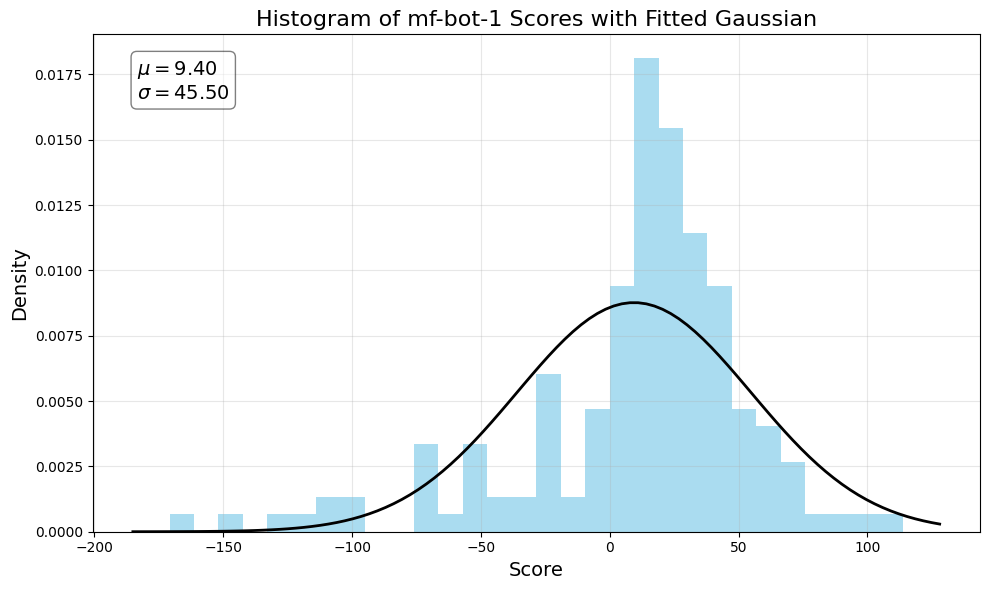

In [33]:
# @title Histogram of bot

# Extract the 'mf-bot-1' column and remove NaN values
#scores = df_bot_vs_pro_peer['FJ_Researcher01+bot'].dropna()

name = 'mf-bot-1'

scores = df_bot_peer_wide[name].dropna()

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(scores, bins=30, density=True, alpha=0.7, color='skyblue')

# Fit a normal distribution to the data
mu, std = norm.fit(scores)

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Customize the plot
plt.title(f"Histogram of {name} Scores with Fitted Gaussian", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Add text box with distribution parameters
textstr = f'$\mu={mu:.2f}$\n$\sigma={std:.2f}$'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
# @title Bootstrapping

def weighted_bootstrap_analysis(df_bot_peer_wide, bots, NUM, ITER):
    # Function to perform a single bootstrap iteration
    def single_bootstrap(df):
        # Weighted sampling of questions
        sampled_df = df.sample(n=NUM, weights='question_weight', replace=True)
        # Calculate total weighted score for each bot
        return sampled_df[bots].sum()

    # Perform bootstrap ITER times
    bootstrap_results = [single_bootstrap(df_bot_peer_wide) for _ in range(ITER)]

    # Convert results to DataFrame
    results_df = pd.DataFrame(bootstrap_results)

    # Calculate confidence intervals and median
    ci_low = results_df.quantile(0.025)
    ci_10 = results_df.quantile(0.1)
    ci_high = results_df.quantile(0.975)
    ci_90 = results_df.quantile(0.9)
    median = results_df.median()

    # Create output DataFrame
    output_df = pd.DataFrame({
        '2.5% CI': ci_low,
        '10% CI': ci_10,
        'Median': median,
        '90% CI': ci_90,
        '97.5% CI': ci_high
    })

    # Sort by median descending
    output_df = output_df.sort_values('Median', ascending=False)

    return output_df

NUM = round(df_bot_peer_wide['question_weight'].sum())
ITER = 1000

result_df = weighted_bootstrap_analysis(df_bot_peer_wide, all_bots, NUM, ITER)
average_df = result_df / NUM

print(f'BOT LEADERBOARD\n\n')
#df_rounded = result_df.round(0).astype(int)
df_rounded = average_df.round(1)
df_rounded


BOT LEADERBOARD




,2.5% CI,10% CI,Median,90% CI,97.5% CI
MWG,9.2,10.7,12.9,15.3,16.6
bot_median,9.6,10.1,11.1,12.1,12.6
histerio,5.5,7.2,10.5,13.5,15.0
mf-bot-1,1.4,4.4,9.4,13.6,16.1
Cassie,3.0,4.8,8.6,11.9,13.4
acm_bot,5.3,6.3,8.1,10.0,11.0
centobot,3.1,4.9,8.0,10.9,12.2
Jay_Bailey_Bot,3.7,5.4,7.6,10.1,11.4
mf-bot-3,-0.1,2.5,7.0,11.5,14.0
annabot,2.9,4.1,6.7,9.3,10.5


In [35]:
NUM = round(df_bot_vs_pro_peer['question_weight'].sum())
ITER = 1000

result_df = weighted_bootstrap_analysis(df_bot_vs_pro_peer, all_bots, NUM, ITER)
average_df = result_df / NUM

print(f'\n\n\nHEAD-TO-HEAD LEADERBOARD\n\n')
#df_rounded = result_df.round(0).astype(int)
df_rounded = average_df.round(1)

df_rounded




HEAD-TO-HEAD LEADERBOARD




,2.5% CI,10% CI,Median,90% CI,97.5% CI
VeritasAI,-6.1,-3.4,1.3,5.6,8.1
nikolabot,-1.0,-0.5,0.7,2.0,2.9
kiko-bot,-3.8,-2.4,0.4,2.9,4.4
lapp0,-2.2,-1.4,0.3,2.4,3.5
mf-bot-3,-5.5,-3.5,0.3,3.7,5.4
royal7,0.0,0.0,0.1,0.3,0.4
egriffiths,-0.6,-0.4,0.1,0.7,1.0
p-bot,-0.6,-0.4,-0.1,0.2,0.3
usmanijan,-3.9,-2.6,-0.2,2.2,3.2
ProfPaul,-4.2,-3.0,-0.5,2.0,3.3


In [37]:
# @title Check specific bot records

bot_name = 'GreeneiBot2'

df_bot = df_bot_peer_wide[['bot_question_id', 'question_weight', bot_name]]
df_bot = df_bot.dropna()
df_bot = df_bot.reset_index(drop=True)

df_bot['weighted_score'] = df_bot[bot_name] * df_bot['question_weight']

weighted_score = df_bot['weighted_score'].sum()

print(f"Weighted score for {bot_name}: {weighted_score}")

total_score = df_bot[bot_name].sum()

print(f"Total score for {bot_name}: {total_score}\n")

# Create the histogram
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.hist(df_bot[bot_name], bins=10, edgecolor='black')

# Customize the plot
plt.title(f'Histogram of Scores for {bot_name}')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Add grid lines (optional)
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

KeyError: "['GreeneiBot2'] not in index"

In [38]:
# @title Weighted Bot Only Peer, T test

df_W_bot_only_peer_leaderboard = pd.DataFrame()

df3 = pd.DataFrame()

for bot in all_bots:

  # T test
  df3 = df_bot_peer_wide[[bot, 'question_weight']]
  df3 = df3.dropna()
  df3 = df3.reset_index(drop=True)
  weighted_score = (df3[bot] * df3['question_weight']).sum()
  weighted_count = df3['question_weight'].sum()
  weighted_average = weighted_score / weighted_count
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
  std_error = weighted_std_dev / np.sqrt(weighted_count)
  t_statistic = (weighted_average - 0) / std_error
  if weighted_count > 2:
    t_crit = t_critical_value(weighted_count - 1)
    # 95% confidence that the true mean is between lower and upper bounds
    upper_bound = weighted_average + t_crit * std_error
    lower_bound = weighted_average - t_crit * std_error
    # 1.96 sigma for a normal Gaussian correponds to 97.5th percentile
    # Normalization below
    cdf = norm.cdf(t_statistic * 1.96 / t_crit)
  else:
    t_crit = np.nan
    upper_bound = np.nan
    lower_bound = np.nan
    cdf = np.nan

  df_W_bot_only_peer_leaderboard.loc[bot, 'W_score'] = weighted_score
  df_W_bot_only_peer_leaderboard.loc[bot, 'W_count'] = weighted_count
  df_W_bot_only_peer_leaderboard.loc[bot, 'W_ave'] = weighted_average
  df_W_bot_only_peer_leaderboard.loc[bot, 'W_stdev'] = weighted_std_dev
  df_W_bot_only_peer_leaderboard.loc[bot, 'std_err'] = std_error
  df_W_bot_only_peer_leaderboard.loc[bot, 't_stat'] = t_statistic
  df_W_bot_only_peer_leaderboard.loc[bot, 't_crit'] = t_crit
  df_W_bot_only_peer_leaderboard.loc[bot, 'upper_bound'] = upper_bound
  df_W_bot_only_peer_leaderboard.loc[bot, 'lower_bound'] = lower_bound
  df_W_bot_only_peer_leaderboard.loc[bot, 'cdf'] = cdf * 100

/tmp/ipykernel_932813/1735572293.py:16: RuntimeWarning: invalid value encountered in scalar divide
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))


In [39]:
# Sort the DataFrame by the lower_bound column in descending order
sorted_df = df_W_bot_only_peer_leaderboard.sort_values(by='lower_bound', ascending=False)

# Get the top 10 bot names
top_10_bots = sorted_df.index[:10].tolist()

# Print the list of top 10 bots
print("Top 10 bots:")
for i, bot in enumerate(top_10_bots, 1):
    print(f"{i}. {bot}")

Top 10 bots:
1. bot_median
2. MWG
3. acm_bot
4. histerio
5. centobot
6. Unwrapped80T
7. Jay_Bailey_Bot
8. manticAI
9. Cassie
10. annabot


In [40]:
# @title Calculate df_bot_team_forecasts

df_bot_team_forecasts = pd.merge(
    df_bot_forecasts,
    df_pro_bot_resolved_questions[['bot_question_id', 'question_weight', 'resolution']],
    on='bot_question_id',
    how='left'
)

columns_to_keep = ['bot_question_id', 'question_weight', 'resolution'] + top_10_bots

# Filter the DataFrame to keep only the specified columns
df_bot_team_forecasts = df_bot_team_forecasts[columns_to_keep]

#print(df_bot_team_forecasts)

# Function to calculate median forecast for a given number of bots
def calculate_median_forecast(df, bots):
    return df[bots].median(axis=1)

# Calculate and add median forecasts for 2 to 10 bots
for i in range(1, 11):
    bots_subset = top_10_bots[:i]
    column_name = f'median_forecast_{i}_bots'
    df_bot_team_forecasts[column_name] = calculate_median_forecast(df_bot_team_forecasts, bots_subset)

# Display the first few rows of the updated DataFrame
df_bot_team_forecasts.head()

,bot_question_id,question_weight,resolution,bot_median,MWG,acm_bot,histerio,centobot,Unwrapped80T,Jay_Bailey_Bot,...,median_forecast_1_bots,median_forecast_2_bots,median_forecast_3_bots,median_forecast_4_bots,median_forecast_5_bots,median_forecast_6_bots,median_forecast_7_bots,median_forecast_8_bots,median_forecast_9_bots,median_forecast_10_bots
0,25871,1.0,no,0.480502,0.486732,NaN,NaN,NaN,NaN,0.509750,...,0.480502,0.483617,0.483617,0.483617,0.483617,0.483617,0.486732,0.493411,0.486732,0.483617
1,25872,1.0,yes,0.455864,0.503548,NaN,NaN,NaN,NaN,0.551596,...,0.455864,0.479706,0.479706,0.479706,0.479706,0.479706,0.503548,0.502637,0.503548,0.502637
2,25873,1.0,yes,0.431146,0.495731,NaN,NaN,NaN,NaN,0.669457,...,0.431146,0.463439,0.463439,0.463439,0.463439,0.463439,0.495731,0.498130,0.500529,0.500264
3,25874,1.0,yes,0.512876,0.500000,NaN,NaN,NaN,NaN,0.551284,...,0.512876,0.506438,0.506438,0.506438,0.506438,0.506438,0.512876,0.506438,0.512876,0.506438
4,25875,1.0,yes,0.734518,0.446859,NaN,NaN,NaN,NaN,0.197633,...,0.734518,0.590688,0.590688,0.590688,0.590688,0.590688,0.446859,0.467934,0.446859,0.411559


In [41]:
# @title Calculate the baseline scores for each team size

teams = ['median_forecast_1_bots',
         'median_forecast_2_bots',
         'median_forecast_3_bots',
         'median_forecast_4_bots',
         'median_forecast_5_bots',
         'median_forecast_6_bots',
         'median_forecast_7_bots',
         'median_forecast_8_bots',
         'median_forecast_9_bots',
         'median_forecast_10_bots']

def calculate_weighted_scores(df_bot_team_forecasts, teams):
    # Initialize a dictionary to store the weighted scores for each team
    team_scores = {team: 0 for team in teams}

    # Iterate through each row (question) in the dataframe
    for _, row in df_bot_team_forecasts.iterrows():
        resolution = row['resolution']
        question_weight = row['question_weight']

        # Calculate the baseline score for each team
        for team in teams:
            forecast = row[team]

            # Calculate the baseline score based on the resolution
            if resolution == 'yes':
                baseline_score = np.log2(forecast / 0.5)
            elif resolution == 'no':
                baseline_score = np.log2((1 - forecast) / 0.5)
            else:
                # Skip if resolution is neither 0 nor 1
                continue

            # Calculate the weighted score and add it to the team's total
            weighted_score = baseline_score * question_weight
            team_scores[team] += weighted_score

    # Convert the dictionary to a pandas Series for easier handling
    return pd.Series(team_scores)

weighted_scores = calculate_weighted_scores(df_bot_team_forecasts, teams)
print(weighted_scores)

median_forecast_1_bots      3.473008
median_forecast_2_bots      8.888937
median_forecast_3_bots     12.137560
median_forecast_4_bots     14.103672
median_forecast_5_bots     12.847414
median_forecast_6_bots     15.116472
median_forecast_7_bots     15.455526
median_forecast_8_bots     15.412537
median_forecast_9_bots     14.713334
median_forecast_10_bots    13.240220
dtype: float64


In [42]:
top_10_bots

['bot_median',
 'MWG',
 'acm_bot',
 'histerio',
 'centobot',
 'Unwrapped80T',
 'Jay_Bailey_Bot',
 'manticAI',
 'Cassie',
 'annabot']

In [43]:
# @title Weighted team-vs-pro

# We have our top bot team members.
# Calculate their median forecast on the pro_bot questions.
# Create df with bot_question_id, forecasts, resolution, weights
# Calculate the head-to-head score

top_bot_team = top_10_bots[:9]
#print(top_bot_team)

df_top_bot_forecasts = df_bot_forecasts[['bot_question_id'] + top_bot_team]
df_top_bot_forecasts['bot_team_median'] = df_top_bot_forecasts[top_bot_team].median(axis=1)
#print(df_top_bot_forecasts)

df_pro_median = df_pro_forecasts[['pro_question_id', 'pro_median']]

df_top_bot_pro_forecasts = pd.merge(
    df_pro_bot_resolved_questions,
    df_top_bot_forecasts[['bot_question_id', 'bot_team_median']],
    on='bot_question_id',
    how='left'
)

df_top_bot_pro_forecasts = pd.merge(
    df_top_bot_pro_forecasts,
    df_pro_median,
    on='pro_question_id',
    how='left'
)

def calculate_head_to_head(row):
    if row['resolution'] == 'yes':
        return 100* np.log(row['bot_team_median'] / row['pro_median'])
    elif row['resolution'] == 'no':
        return 100* np.log((1 - row['bot_team_median']) / (1 - row['pro_median']))
    else:
        return np.nan

# Add the head_to_head column
df_top_bot_pro_forecasts['head_to_head'] = df_top_bot_pro_forecasts.apply(calculate_head_to_head, axis=1)

df_top_bot_pro_forecasts

/tmp/ipykernel_932813/3401039070.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_bot_forecasts['bot_team_median'] = df_top_bot_forecasts[top_bot_team].median(axis=1)


,pro_question_id,title,resolution,scheduled_close_time,actual_close_time,bot_question_id,question_weight,bot_team_median,pro_median,head_to_head
0,25887,"On July 17, 2024, will Nvidia's market capital...",no,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,25871,1.0,0.486732,0.246005,-38.458850
1,25888,Will 4 or more goals be scored in the two semi...,yes,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,25872,1.0,0.503548,0.592482,-16.264121
2,25889,Will the Real-time Sahm Rule Recession Indicat...,yes,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,25873,1.0,0.500529,0.702690,-33.925034
3,25890,Will the time gap between the first and second...,yes,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,25874,1.0,0.512876,0.487529,5.068559
4,25891,"Will Joe Biden announce before July 31, 2024 t...",yes,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,25875,1.0,0.446859,0.328933,30.638658
...,...,...,...,...,...,...,...,...,...,...
152,28062,Will AfD's vote share be more than 32% in the ...,no,2024-09-13 14:30:00+00,2024-09-13 14:30:00+00,28042,1.0,0.361949,0.415799,8.817377
153,28063,Will AfD's vote share be more than 30% and les...,no,2024-09-13 14:30:00+00,2024-09-13 14:30:00+00,28043,1.0,0.384917,0.463208,13.614717
154,28064,Will AfD's vote share be more than 28% and les...,yes,2024-09-13 14:30:00+00,2024-09-13 14:30:00+00,28044,1.0,0.420577,0.418377,0.524483
155,28065,Will AfD's vote share be less than or equal to...,no,2024-09-13 14:30:00+00,2024-09-13 14:30:00+00,28045,1.0,0.456162,0.426498,-5.310941


In [44]:
df_top_bot_pro_forecasts.head()

,pro_question_id,title,resolution,scheduled_close_time,actual_close_time,bot_question_id,question_weight,bot_team_median,pro_median,head_to_head
0,25887,"On July 17, 2024, will Nvidia's market capital...",no,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,25871,1.0,0.486732,0.246005,-38.458850
1,25888,Will 4 or more goals be scored in the two semi...,yes,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,25872,1.0,0.503548,0.592482,-16.264121
2,25889,Will the Real-time Sahm Rule Recession Indicat...,yes,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,25873,1.0,0.500529,0.702690,-33.925034
3,25890,Will the time gap between the first and second...,yes,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,25874,1.0,0.512876,0.487529,5.068559
4,25891,"Will Joe Biden announce before July 31, 2024 t...",yes,2024-07-09 14:30:00+00,2024-07-09 14:30:00+00,25875,1.0,0.446859,0.328933,30.638658


In [45]:
# Calculate the weighted score for each row
df_top_bot_pro_forecasts['weighted_score'] = df_top_bot_pro_forecasts['head_to_head'] * df_top_bot_pro_forecasts['question_weight']

# Calculate the total weighted score
total_weighted_score = df_top_bot_pro_forecasts['weighted_score'].sum()

# Calculate the sum of weights
total_weight = df_top_bot_pro_forecasts['question_weight'].sum()

# Calculate the weighted total score
weighted_total_score = total_weighted_score / total_weight

print(f"Weighted Total Score: {weighted_total_score:.4f}")

Weighted Total Score: -6.2888


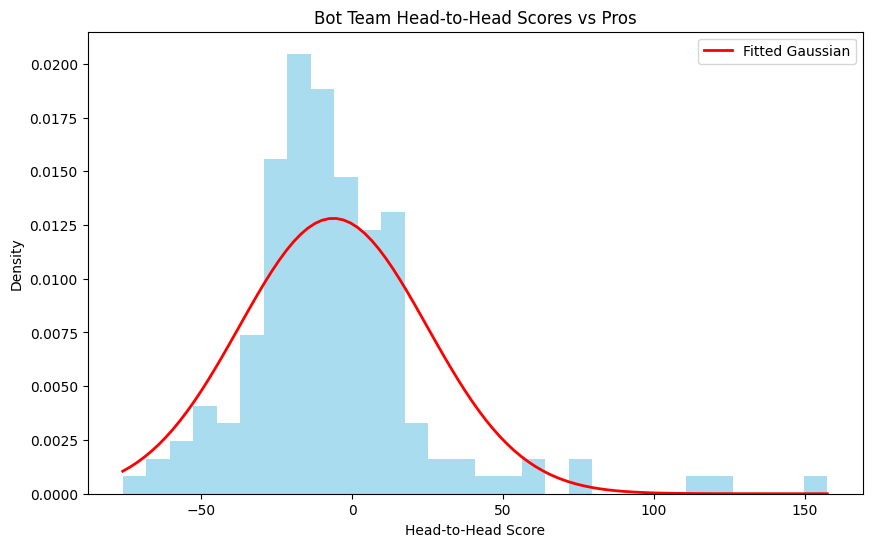

The average of 'head_to_head' is: -6.29


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming df_top_bot_pro_forecasts is already defined and contains the 'head_to_head' column

# Extract the 'head_to_head' data
data = df_top_bot_pro_forecasts['head_to_head']

# Calculate the mean and standard deviation
mean = np.mean(data)
std = np.std(data)

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(data, bins=30, density=True, alpha=0.7, color='skyblue')

# Generate points for the fitted Gaussian curve
x = np.linspace(min(data), max(data), 100)
y = norm.pdf(x, mean, std)

# Plot the fitted Gaussian curve
plt.plot(x, y, 'r-', linewidth=2, label='Fitted Gaussian')

# Customize the plot
plt.title('Bot Team Head-to-Head Scores vs Pros')
plt.xlabel('Head-to-Head Score')
plt.ylabel('Density')
plt.legend()

# Add text annotation for the mean
#plt.text(0.95, 0.95, f'Mean: {mean:.2f}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

# Display the plot
plt.show()

# Print the average
print(f"The average of 'head_to_head' is: {mean:.2f}")

In [47]:

df3 = df_top_bot_pro_forecasts.copy()

df3 = df3[['head_to_head', 'question_weight']]
df3 = df3.dropna()
df3 = df3.reset_index(drop=True)
weighted_score = (df3['head_to_head'] * df3['question_weight']).sum()
weighted_count = df3['question_weight'].sum()
weighted_average = weighted_score / weighted_count
weighted_std_dev = np.sqrt(((df3['head_to_head'] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
std_error = weighted_std_dev / np.sqrt(weighted_count)
t_statistic = (weighted_average - 0) / std_error
if weighted_count > 2:
  t_crit = t_critical_value(weighted_count - 1)
  # 95% confidence that the true mean is between lower and upper bounds
  upper_bound = weighted_average + t_crit * std_error
  lower_bound = weighted_average - t_crit * std_error
  # 1.96 sigma for a normal Gaussian correponds to 97.5th percentile
  # Normalization below
  cdf = norm.cdf(t_statistic * 1.96 / t_crit)
else:
  t_crit = np.NaN
  upper_bound = np.NaN
  lower_bound = np.NaN
  cdf = np.NaN

df_bot_team_h2h = pd.DataFrame()

df_bot_team_h2h.loc[bot, 'W_score'] = weighted_score
df_bot_team_h2h.loc[bot, 'W_count'] = weighted_count
df_bot_team_h2h.loc[bot, 'W_ave'] = weighted_average
df_bot_team_h2h.loc[bot, 'W_stdev'] = weighted_std_dev
df_bot_team_h2h.loc[bot, 'std_err'] = std_error
df_bot_team_h2h.loc[bot, 't_stat'] = t_statistic
df_bot_team_h2h.loc[bot, 't_crit'] = t_crit
df_bot_team_h2h.loc[bot, 'upper_bound'] = upper_bound
df_bot_team_h2h.loc[bot, 'lower_bound'] = lower_bound
df_bot_team_h2h.loc[bot, 'cdf'] = cdf * 100

print(df_bot_team_h2h)

            W_score  W_count    W_ave    W_stdev  std_err    t_stat  t_crit  \
annabot -987.338402    157.0 -6.28878  31.242968  2.49346 -2.522109   1.983   

         upper_bound  lower_bound     cdf  
annabot    -1.344248   -11.233311  0.6336  


In [48]:
df_sorted = df_top_bot_pro_forecasts.sort_values(by='head_to_head')

df_top5 = df_sorted.head(5)
df_bottom5 = df_sorted.tail(5)

print("Top 5:")

df_top5[['title', 'bot_team_median', 'pro_median', 'resolution', 'head_to_head']]

Top 5:


,title,bot_team_median,pro_median,resolution,head_to_head
146,Will Intel get dropped from the Dow Jones Indu...,0.649370,0.250212,no,-76.005834
77,Will Donald Trump have more than 15 million Ti...,0.643964,0.307172,no,-66.574924
100,Will the Crimean Bridge be hit with an attack ...,0.576357,0.211708,no,-62.097646
140,Will Edmundo González be deprived of liberty b...,0.635614,0.350821,no,-57.749536
45,Will the Atlantic Ocean's daily mean sea surfa...,0.679015,0.453970,no,-53.127821


In [49]:
print("\nBottom 5:")

df_bottom5[['title', 'bot_team_median', 'pro_median', 'resolution', 'head_to_head']]


Bottom 5:


,title,bot_team_median,pro_median,resolution,head_to_head
26,"Before August 22, 2024, will President Joe Bid...",0.403708,0.191847,yes,74.399259
16,Will exactly 1 Starship launch reach an altitu...,0.475389,0.760151,no,78.264526
18,Will exactly 1 or 2 Starship launches reach an...,0.575223,0.860550,no,111.385495
145,Will China's youth unemployment rate be greate...,0.469592,0.135525,yes,124.270957
27,Will Kimberly Cheatle remain Director of the U...,0.547999,0.906338,no,157.399456


In [50]:
# Cast df_top_bot_pro_forecasts['resolution'] as string - idk why this is necessary but it is
df_top_bot_pro_forecasts['resolution'] = df_top_bot_pro_forecasts['resolution'].astype(pd.StringDtype())
df_top_bot_pro_forecasts['resolution'] = df_top_bot_pro_forecasts['resolution'].map({'yes': 1, 'no': 0})
df_top_bot_pro_forecasts.dtypes

pro_question_id           int64
title                    object
resolution                int64
scheduled_close_time     object
actual_close_time        object
bot_question_id           int64
question_weight         float64
bot_team_median         float64
pro_median              float64
head_to_head            float64
weighted_score          float64
dtype: object

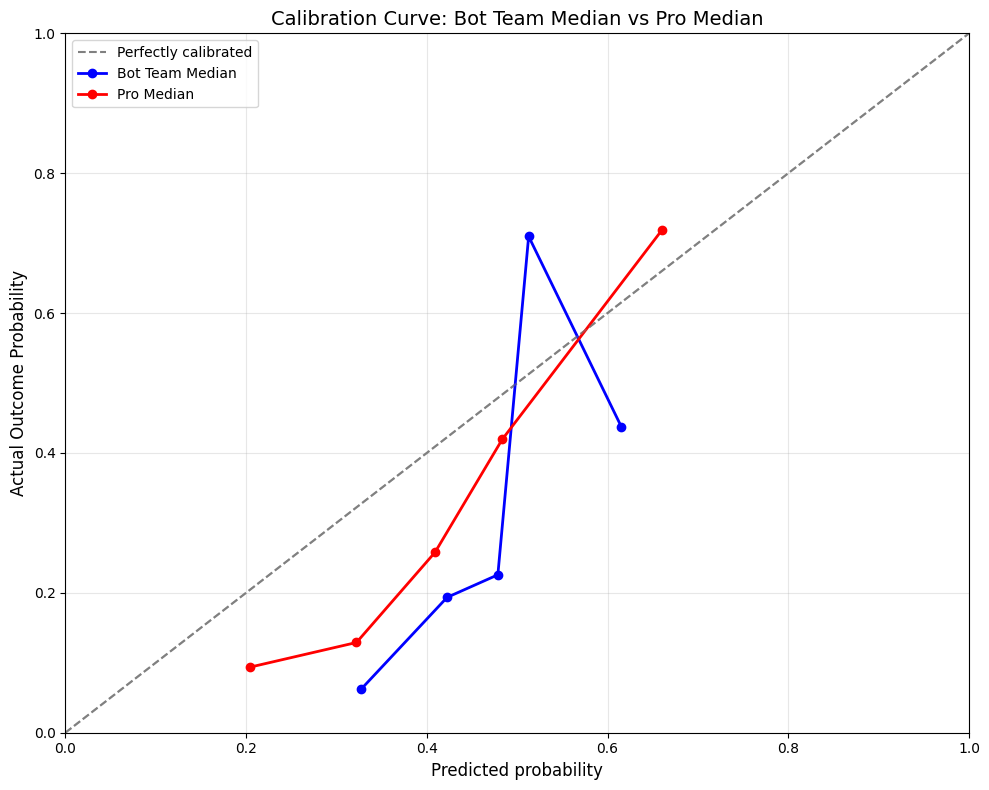

In [51]:
# TK: Make this nice calibration curve with error bars

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import numpy as np
import pdb

# Function to plot calibration curve
def plot_calibration_curve(df, column_name, label, color):

    # Extract actual outcomes and predictions
    y_true = df['resolution']
    y_pred = df[column_name]

    # Calculate calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=5, strategy='quantile')

    # Plot calibration curve
    plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label=label, color=color)

# Set up the plot
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

# Plot calibration curves for bot_team_median and pro_median
plot_calibration_curve(df_top_bot_pro_forecasts, 'bot_team_median', 'Bot Team Median', 'blue')
plot_calibration_curve(df_top_bot_pro_forecasts, 'pro_median', 'Pro Median', 'red')

# Customize the plot
plt.xlabel('Predicted probability', fontsize=12)
plt.ylabel('Actual Outcome Probability', fontsize=12)
plt.title('Calibration Curve: Bot Team Median vs Pro Median', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add diagonal line for perfect calibration
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.5)

# Set axis limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Show the plot
plt.tight_layout()
plt.show()

In [52]:
import numpy as np
import pandas as pd

# Assuming df_top_bot_pro_forecasts is already defined

def calculate_confidence(predictions, outcomes):
    """
    Calculate over- or under-confidence for a set of predictions.

    :param predictions: Series of predicted probabilities
    :param outcomes: Series of actual outcomes (0 or 1)
    :return: Confidence score (positive for overconfidence, negative for underconfidence)
    """
    # Bin predictions into 10 equally spaced bins
    bins = pd.cut(predictions, bins=10)

    # Calculate mean prediction and actual outcome for each bin
    grouped = pd.DataFrame({'prediction': predictions, 'outcome': outcomes}).groupby(bins)
    mean_prediction = grouped['prediction'].mean()
    mean_outcome = grouped['outcome'].mean()

    # Calculate the difference between mean prediction and mean outcome
    confidence_diff = mean_prediction - mean_outcome

    # Return the average difference (excluding NaN values)
    return np.nanmean(confidence_diff)

# Calculate confidence scores for bot_team_median and pro_median
bot_confidence = calculate_confidence(df_top_bot_pro_forecasts['bot_team_median'], df_top_bot_pro_forecasts['resolution'])
pro_confidence = calculate_confidence(df_top_bot_pro_forecasts['pro_median'], df_top_bot_pro_forecasts['resolution'])

print(f"Bot team confidence score: {bot_confidence:.4f}")
print(f"Pro team confidence score: {pro_confidence:.4f}")

# Interpret the results
def interpret_confidence(score):
    if score > 0:
        return f"Overconfident by {score:.4f}"
    elif score < 0:
        return f"Underconfident by {abs(score):.4f}"
    else:
        return "Perfectly calibrated"

print(f"Bot team is {interpret_confidence(bot_confidence)}")
print(f"Pro team is {interpret_confidence(pro_confidence)}")

Bot team confidence score: 0.1915
Pro team confidence score: 0.0892
Bot team is Overconfident by 0.1915
Pro team is Overconfident by 0.0892


/tmp/ipykernel_932813/3215770322.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = pd.DataFrame({'prediction': predictions, 'outcome': outcomes}).groupby(bins)


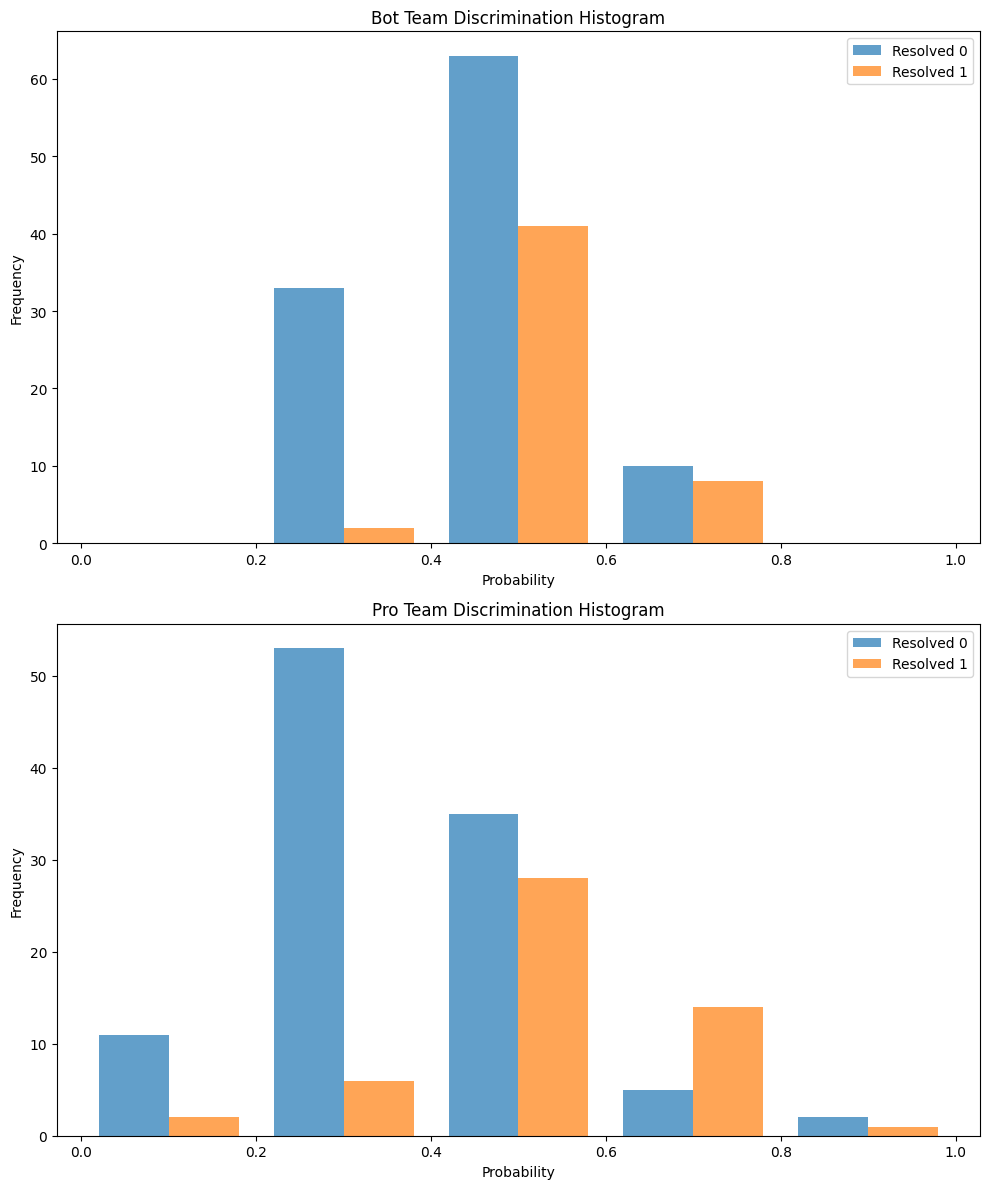

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_top_bot_pro_forecasts is already loaded
# If not, you would load it here:
# df_top_bot_pro_forecasts = pd.read_csv('your_data.csv')

def create_discrimination_histogram(df, bot_col, pro_col, resolution_col):
    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Define bin edges
    #bins = np.linspace(0, 1, 11)
    bins = np.linspace(0, 1, 6)

    # Bot team histogram
    ax1.hist([df[df[resolution_col] == 0][bot_col],
              df[df[resolution_col] == 1][bot_col]],
             bins=bins, label=['Resolved 0', 'Resolved 1'], alpha=0.7)
    ax1.set_title('Bot Team Discrimination Histogram')
    ax1.set_xlabel('Probability')
    ax1.set_ylabel('Frequency')
    ax1.legend()

    # Pro team histogram
    ax2.hist([df[df[resolution_col] == 0][pro_col],
              df[df[resolution_col] == 1][pro_col]],
             bins=bins, label=['Resolved 0', 'Resolved 1'], alpha=0.7)
    ax2.set_title('Pro Team Discrimination Histogram')
    ax2.set_xlabel('Probability')
    ax2.set_ylabel('Frequency')
    ax2.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame and column names
create_discrimination_histogram(df_top_bot_pro_forecasts,
                                'bot_team_median',
                                'pro_median',
                                'resolution')

In [54]:

# Calculate average forecasts for resolved 1 and 0 for bots
bot_avg_1 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 1]['bot_team_median'].mean()
bot_avg_0 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 0]['bot_team_median'].mean()

# Calculate average forecasts for resolved 1 and 0 for pros
pro_avg_1 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 1]['pro_median'].mean()
pro_avg_0 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution'] == 0]['pro_median'].mean()

# Calculate the differences
bot_difference = bot_avg_1 - bot_avg_0
pro_difference = pro_avg_1 - pro_avg_0

print(f"Bot average forecast difference (1 - 0): {bot_difference:.4f}")
print(f"Pro average forecast difference (1 - 0): {pro_difference:.4f}")

# Calculate the difference between pro and bot differences
pro_bot_difference = pro_difference - bot_difference
print(f"Difference between pro and bot differences: {pro_bot_difference:.4f}")

Bot average forecast difference (1 - 0): 0.0737
Pro average forecast difference (1 - 0): 0.1515
Difference between pro and bot differences: 0.0778


In [55]:
# TK: Ask Tom for scope sensitivity questions?

# Assuming df_top_bot_pro_forecasts is already loaded

if False:

    def get_forecast(question_id):
        forecast = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['bot_question_id'] == question_id]['bot_team_median'].values
        return forecast[0] if len(forecast) > 0 else np.nan

    def process_scope_questions(bot_scope_questions):
        scope_ratios = []

        for question_tuple in bot_scope_questions:
            forecasts = [get_forecast(qid) for qid in question_tuple]

            print(f"Forecasts for questions {question_tuple}: {forecasts}")

            if not any(np.isnan(forecasts)):
                scope_ratio = forecasts[0] / (forecasts[1] + forecasts[2])
                print(f"Scope ratio: {scope_ratio:.4f}")
                scope_ratios.append(scope_ratio)
            else:
                print("Unable to calculate scope ratio due to missing forecast(s)")

            print()  # Empty line for readability

        return scope_ratios

    # Process the bot_scope_questions
    scope_ratios = process_scope_questions(bot_scope_questions)

    # Calculate and print the average scope ratio
    if scope_ratios:
        average_scope_ratio = sum(scope_ratios) / len(scope_ratios)
        print(f"Average scope ratio: {average_scope_ratio:.4f}")
    else:
        print("No valid scope ratios to average")

In [56]:
# Calculate weighted number of 1 resolutions
weighted_ones = np.sum(
    df_top_bot_pro_forecasts['resolution'] *
    df_top_bot_pro_forecasts['question_weight']
)

# Calculate weighted number of 0 resolutions
weighted_zeros = np.sum(
    (1 - df_top_bot_pro_forecasts['resolution']) *
    df_top_bot_pro_forecasts['question_weight']
)

print(f"Weighted number of 1 resolutions: {weighted_ones}")
print(f"Weighted number of 0 resolutions: {weighted_zeros}")

print(f"Average 1 resolutions: {weighted_ones / (weighted_zeros + weighted_ones)}")

Weighted number of 1 resolutions: 51.0
Weighted number of 0 resolutions: 106.0
Average 1 resolutions: 0.3248407643312102
